In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
import scipy.io
from matplotlib import cm, colors
import mne
from scipy.signal import coherence, hilbert

In [2]:
edf_path = r"C:\Users\Juan\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf"
sfreq_target = 256            # Frecuencia de muestreo a la que normalizamos (Hz)
fmin, fmax = 8, 13 
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
data = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)
# ====== 1. MATRIZ DE CORRELACIÓN DE PEARSON ======
corr_matrix = np.corrcoef(data)
corr_df = pd.DataFrame(corr_matrix, index=ch_names, columns=ch_names)
corr_df.to_csv("connectivity_pearson.csv")

# ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(data[i], data[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

coh_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
coh_df.to_csv("connectivity_coherence.csv")

# ====== 3. MATRIZ DE PHASE LOCKING VALUE (PLV) ======
analytic_signal = hilbert(data)
phase_data = np.angle(analytic_signal)

plv_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        phase_diff = phase_data[i] - phase_data[j]
        plv_matrix[i, j] = np.abs(np.sum(np.exp(1j * phase_diff)) / phase_diff.size)

plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)
# plv_df.to_csv("connectivity_plv.csv")

Extracting EDF parameters from C:\Users\Juan\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\Juan\AppData\Local\Temp\ipykernel_1256\435439787.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [3]:
prom = np.mean(coh_matrix.ravel())
coh_matrix_umbral = np.where(coh_matrix < prom, 0, coh_matrix)
coh_df_umbral = pd.DataFrame(data = coh_matrix_umbral)
GGG = nx.from_pandas_adjacency(coh_df_umbral)
####Hubs (por grado)
degree_dict2 = dict(GGG.degree()) #Hacer diccionario con nodo:grado
hubs = sorted(degree_dict2.items(), key=lambda x: x[1], reverse=True)#Ordenar de mayor a menor
top_hubs2 = hubs[:10] # Mostrar los 10 nodos más conectados
print("Hubs (por grado):")
for node, deg in top_hubs2:
    print(f"Nodo {node}: grado {deg}")
####Grado
df_grado2 = pd.DataFrame(index = range(23), columns = ['Nodo', 'Grado'])
i = 0
for entrada in degree_dict2:
    df_grado2.iloc[i,0] = i
    df_grado2.iloc[i,1] = degree_dict2[i]
    i += 1

Hubs (por grado):
Nodo 6: grado 10
Nodo 10: grado 9
Nodo 11: grado 8
Nodo 17: grado 8
Nodo 3: grado 7
Nodo 5: grado 7
Nodo 15: grado 7
Nodo 4: grado 6
Nodo 0: grado 5
Nodo 8: grado 5


In [4]:
####Comunidades
comm = nx.community.greedy_modularity_communities(GGG) #Algoritmo Clauset-Newman-Moore que busca 
#la división de nodos en comunidades que tenga más conexiones dentro que entre ellas.
print('El número de comunidades es: ', len(comm))

El número de comunidades es:  7


In [5]:
comm[0], comm[1], comm[2], comm[3], comm[4], comm[5], comm[6]

(frozenset({3, 7, 11, 15, 17}),
 frozenset({5, 9, 13, 16, 21}),
 frozenset({0, 4, 8, 12}),
 frozenset({2, 6, 18}),
 frozenset({10, 14, 22}),
 frozenset({1, 19}),
 frozenset({20}))

In [6]:
df_grado2


for nodo in df_grado2:
    

SyntaxError: incomplete input (3522424442.py, line 5)

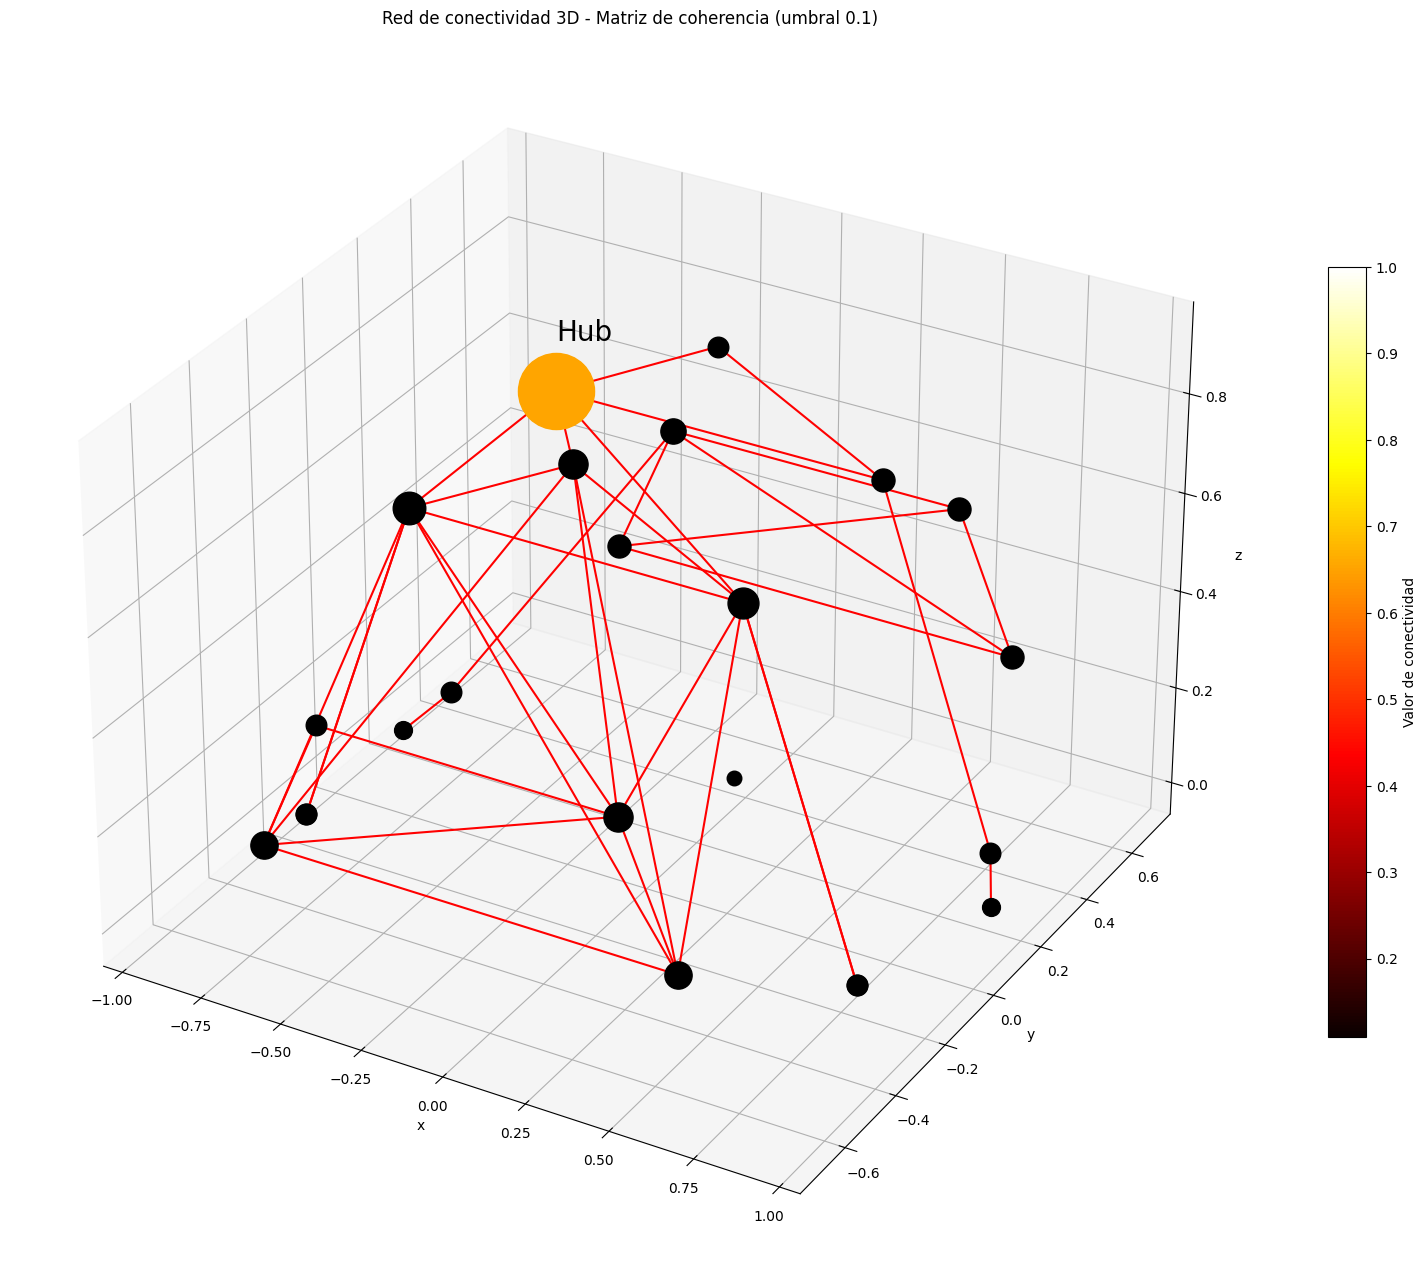

In [7]:
coord_eeg = pd.read_csv(r'C:\Users\Juan\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\coordenadas_bipolares_eeg.csv')
coord_eeg
coord_df = pd.DataFrame(coord_eeg)

GG = nx.from_pandas_adjacency(coh_df_umbral)

pos3D = {nodo: (coord_df.iloc[nodo, 1],
                coord_df.iloc[nodo, 2],
                coord_df.iloc[nodo, 3]) for nodo in coord_df.index}

tamaños = df_grado2.Grado
tamaños = tamaños.values

valores = coh_df_umbral.values[np.triu_indices_from(coh_df_umbral, k=1)]
valores = valores[valores > 0]
vmin = valores.min()
vmax = valores.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.hot

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

j = 0
for i, (x, y, z) in pos3D.items():
    if j==5:
        ax.scatter(x, y, z, s=3000, c='orange')
        ax.text(x, y, z+0.1, 'Hub', size=20)
        j += 1
        i += 1
    else:
        ax.scatter(x, y, z, s=tamaños[i]*55, c='black')
        j += 1

colores = ['#3b7eeb', '#940c96', '#d60b44', '#99e014', '#37edc9', '#ebe34b', '#0a0a0a']

for i, j, data in GG.edges(data=True):
    x = [pos3D[i][0], pos3D[j][0]]
    y = [pos3D[i][1], pos3D[j][1]]
    z = [pos3D[i][2], pos3D[j][2]]
    #valor = coh_df_umbral.iloc[i, j]
    #valor_norm = norm(valor)
    #color = cmap(valor_norm)
    ax.plot(x, y, z, c='red')


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Red de conectividad 3D - Matriz de coherencia (umbral 0.1)')

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label('Valor de conectividad')

plt.show()

In [ ]:
coord_df